# 🚗 Car Model Classification with OOD Detection using Multi-Head Architecture

## 1. Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
from PIL import Image
from typing import List, Tuple
import random
from pathlib import Path
import torch.nn.functional as F


In [ ]:
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

cuda


## 1. Custom Dataset Class for OOD Detection

In [ ]:
class CarDatasetWithOOD(Dataset):
  def __init__(self, root_dir, transform=None):
    self.transform = transform
    self.samples = []

    # car classes (4 car classes)
    car_classes =  ['Maruti_Suzuki_Baleno', 'Maruti_Suzuki_Brezza',
                    'Maruti_Suzuki_Swift', 'Maruti_Suzuki_WagonR']

    # Add car samples
    for idx, class_name in enumerate(car_classes):
      class_path = os.path.join(root_dir, class_name)

      if os.path.exists(class_path):
        for img_name in os.listdir(class_path):
          if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            self.samples.append({
                'path': os.path.join(class_path, img_name),
                'car_class': idx,      # 0,1,2,3
                'is_car': 1            # Binary: this is a car
            })

    # Add OOD samples (Not_Car folder)
    ood_path = os.path.join(root_dir, "Not_Car")
    if os.path.exists(ood_path):
      for img_name in os.listdir(ood_path):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
          self.samples.append({
              'path': os.path.join(ood_path, img_name),
              'car_class': -1,   # No car class
              'is_car': 0        # Binary: this is NOT a Car
          })

    print(f"Loaded {len(self.samples)} samples from {root_dir}")

    # Count distribution
    car_count = 0
    ood_count = 0

    for sample in self.samples:
      if sample["is_car"] == 1:
        car_count += 1
      else:
        ood_count += 1

    print(f"Car Images: {car_count}, OOD Images: {ood_count}")

  def __len__(self):
    return len(self.samples)

  def __getitem__(self,idx):
    sample = self.samples[idx]
    image = Image.open(sample['path']).convert('RGB')

    if self.transform:
      image = self.transform(image)

    return image, sample['car_class'], sample['is_car']

## 2. Multi-Head Model Architecture

In [ ]:
class CarClassifierWithOOD(nn.Module):
  def __init__(self, num_car_classes=4, pretrained=True):
    super(CarClassifierWithOOD, self).__init__()

    # Load EfficientNet-B0 backbone
    if pretrained:
      weights = models.EfficientNet_B0_Weights.DEFAULT
    else:
      weights = None

    self.backbone = models.efficientnet_b0(weights=weights)

    # Remove the original classifier
    self.backbone.classifier = nn.Identity()

    # Freeze base layers
    for param in self.backbone.features.parameters():
        param.requires_grad = False

    # Unfreeze last 2 blocks for fine-tuning
    for param in self.backbone.features[-2:].parameters():
        param.requires_grad = True

    # Feature dimension for EfficientNet-B0
    feature_dim = 1280

    # Car classification head (4 classes)
    self.car_classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(feature_dim, num_car_classes)
    )

    # OOD detection head (binary: car vs not-car)
    self.ood_classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(feature_dim, 1)
    )

  def forward(self, x):
    # Extract features from backbone
    features = self.backbone(x)

    # Get predictions from both heads
    car_logits = self.car_classifier(features)  # [batch_size, 4]
    ood_logits = self.ood_classifier(features)  # [batch_size, 1]

    return car_logits, ood_logits

## 3. Data Preparation

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456, 0.406],
                       std=[0.229,0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                       std=[0.229,0.224,0.225])
])

#### Load datasets with custom dataset class


In [ ]:
train_dir = "./dataset/train"
val_dir = "./dataset/val"
test_dir = "./dataset/test"

In [ ]:
# 1. Training Dataset
train_data = CarDatasetWithOOD(train_dir, transform=train_transform)

# 2. Validation Dataset
val_data = CarDatasetWithOOD(val_dir, transform=test_transform)

# 3. Test Dataset
test_data = CarDatasetWithOOD(test_dir, transform=test_transform)

Loaded 573 samples from ./dataset/train
Car Images: 392, OOD Images: 181
Loaded 124 samples from ./dataset/val
Car Images: 83, OOD Images: 41
Loaded 125 samples from ./dataset/test
Car Images: 88, OOD Images: 37


In [ ]:
# Class names for car classification
class_names = ['Maruti_Suzuki_Baleno', 'Maruti_Suzuki_Brezza',
               'Maruti_Suzuki_Swift', 'Maruti_Suzuki_WagonR']

In [ ]:
BATCH_SIZE = 42

In [ ]:
# 1. Training DataLoader
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# 2. Validation DataLoader
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# 3. Test DataLoader
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## 4. Initialize Multi-Head Model

In [ ]:
model = CarClassifierWithOOD(num_car_classes=4, pretrained=True).to(device)

In [ ]:
# !pip install torchinfo

In [ ]:
# Display model summary
from torchinfo import summary
summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=19,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape         Output Shape        Param #             Trainable
CarClassifierWithOOD (CarClassifierWithOOD)                       [32, 3, 224, 224]   [32, 4]             --                  Partial
├─EfficientNet (backbone)                                         [32, 3, 224, 224]   [32, 1280]          --                  Partial
│    └─Sequential (features)                                      [32, 3, 224, 224]   [32, 1280, 7, 7]    --                  Partial
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]   [32, 32, 112, 112]  (928)               False
│    │    └─Sequential (1)                                        [32, 32, 112, 112]  [32, 16, 112, 112]  (1,448)             False
│    │    └─Sequential (2)                                        [32, 16, 112, 112]  [32, 24, 56, 56]    (16,714)            False
│    │    └─Sequential (3)                                        

## 5. Training Components

In [ ]:
LEARNING_RATE = 0.001

In [ ]:
# 1.Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# 2. Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=2, factor=0.5)

## Implement Early Stopping

In [ ]:
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0.001):
    self.patience = patience      # How many epochs to wait before stopping
    self.min_delta = min_delta    # Minimum improvement threshold
    self.counter = 0              # Count epochs without improvement
    self.best_loss = None         # Track the best validation loss seen
    self.early_stop = False       # Flag to indicate when to stop training


  def __call__(self, val_loss):
    if self.best_loss is None:
        # First epoch - initialize best loss
        self.best_loss = val_loss

    elif val_loss < self.best_loss - self.min_delta:
        # Significant improvement found
        self.best_loss = val_loss
        self.counter = 0  # Reset patience counter

    else:
        # No significant improvement
        self.counter += 1
        if self.counter >= self.patience:
            self.early_stop = True  # Trigger early stopping

## 6. Updated Training Functions with Dual Loss

In [ ]:
def compute_dual_loss(car_logits, ood_logits, car_labels, is_car_labels, car_weight=1.0, ood_weight=0.5):
    """
    Compute combined loss for both car classification and OOD detection
    """
    # Car classification loss (only for car images)
    car_mask = is_car_labels == 1
    if car_mask.sum() > 0:
        car_loss = F.cross_entropy(car_logits[car_mask], car_labels[car_mask])
    else:
        car_loss = torch.tensor(0.0, device=car_logits.device)

    # OOD detection loss (for all images)
    ood_loss = F.binary_cross_entropy_with_logits(
        ood_logits.squeeze(), is_car_labels.float()
    )

    # Combined loss
    total_loss = car_weight * car_loss + ood_weight * ood_loss
    return total_loss, car_loss, ood_loss

In [ ]:
def train_step_dual(model, dataloader, optimizer, device):
    model.train()
    total_loss, car_loss_sum, ood_loss_sum = 0, 0, 0
    car_correct, ood_correct, car_total, ood_total = 0, 0, 0, 0

    for images, car_labels, is_car_labels in dataloader:
        images = images.to(device)
        car_labels = car_labels.to(device)
        is_car_labels = is_car_labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        car_logits, ood_logits = model(images)

        # Compute dual loss
        loss, car_loss, ood_loss = compute_dual_loss(
            car_logits, ood_logits, car_labels, is_car_labels
        )

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate losses
        total_loss += loss.item()
        car_loss_sum += car_loss.item()
        ood_loss_sum += ood_loss.item()

        # Calculate accuracies
        # Car classification accuracy (only for car images)
        car_mask = is_car_labels == 1
        if car_mask.sum() > 0:
            car_pred = torch.argmax(car_logits[car_mask], dim=1)
            car_correct += (car_pred == car_labels[car_mask]).sum().item()
            car_total += car_mask.sum().item()

        # OOD detection accuracy (for all images)
        ood_pred = (torch.sigmoid(ood_logits.squeeze()) > 0.5).float()
        ood_correct += (ood_pred == is_car_labels.float()).sum().item()
        ood_total += len(is_car_labels)

    # Calculate averages
    avg_total_loss = total_loss / len(dataloader)
    avg_car_loss = car_loss_sum / len(dataloader)
    avg_ood_loss = ood_loss_sum / len(dataloader)
    car_acc = car_correct / car_total if car_total > 0 else 0
    ood_acc = ood_correct / ood_total

    return avg_total_loss, avg_car_loss, avg_ood_loss, car_acc, ood_acc

In [ ]:
def test_step_dual(model, dataloader, device):
    model.eval()
    total_loss, car_loss_sum, ood_loss_sum = 0, 0, 0
    car_correct, ood_correct, car_total, ood_total = 0, 0, 0, 0

    with torch.no_grad():
        for images, car_labels, is_car_labels in dataloader:
            images = images.to(device)
            car_labels = car_labels.to(device)
            is_car_labels = is_car_labels.to(device)

            # Forward pass
            car_logits, ood_logits = model(images)

            # Compute dual loss
            loss, car_loss, ood_loss = compute_dual_loss(
                car_logits, ood_logits, car_labels, is_car_labels
            )

            # Accumulate losses
            total_loss += loss.item()
            car_loss_sum += car_loss.item()
            ood_loss_sum += ood_loss.item()

            # Calculate accuracies
            car_mask = is_car_labels == 1
            if car_mask.sum() > 0:
                car_pred = torch.argmax(car_logits[car_mask], dim=1)
                car_correct += (car_pred == car_labels[car_mask]).sum().item()
                car_total += car_mask.sum().item()

            ood_pred = (torch.sigmoid(ood_logits.squeeze()) > 0.5).float()
            ood_correct += (ood_pred == is_car_labels.float()).sum().item()
            ood_total += len(is_car_labels)

    avg_total_loss = total_loss / len(dataloader)
    avg_car_loss = car_loss_sum / len(dataloader)
    avg_ood_loss = ood_loss_sum / len(dataloader)
    car_acc = car_correct / car_total if car_total > 0 else 0
    ood_acc = ood_correct / ood_total

    return avg_total_loss, avg_car_loss, avg_ood_loss, car_acc, ood_acc

## 7. Updated Training Loop

In [ ]:
def train_dual_head(model, train_loader, val_loader, optimizer, epochs, device, early_stopping, scheduler):
    results = {
        "train_loss": [], "train_car_loss": [], "train_ood_loss": [],
        "train_car_acc": [], "train_ood_acc": [],
        "val_loss": [], "val_car_loss": [], "val_ood_loss": [],
        "val_car_acc": [], "val_ood_acc": []
    }

    for epoch in tqdm(range(epochs), desc="Training"):
        # Training
        train_loss, train_car_loss, train_ood_loss, train_car_acc, train_ood_acc = train_step_dual(
            model, train_loader, optimizer, device
        )

        # Validation
        val_loss, val_car_loss, val_ood_loss, val_car_acc, val_ood_acc = test_step_dual(
            model, val_loader, device
        )

        # Display results
        print(f"Epoch: {epoch+1}")
        print(f"  Train - Total: {train_loss:.4f} | Car: {train_car_loss:.4f} ({train_car_acc:.4f}) | OOD: {train_ood_loss:.4f} ({train_ood_acc:.4f})")
        print(f"  Val   - Total: {val_loss:.4f} | Car: {val_car_loss:.4f} ({val_car_acc:.4f}) | OOD: {val_ood_loss:.4f} ({val_ood_acc:.4f})")

        # Store results
        results["train_loss"].append(train_loss)
        results["train_car_loss"].append(train_car_loss)
        results["train_ood_loss"].append(train_ood_loss)
        results["train_car_acc"].append(train_car_acc)
        results["train_ood_acc"].append(train_ood_acc)

        results["val_loss"].append(val_loss)
        results["val_car_loss"].append(val_car_loss)
        results["val_ood_loss"].append(val_ood_loss)
        results["val_car_acc"].append(val_car_acc)
        results["val_ood_acc"].append(val_ood_acc)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return results

## 8. Updated Prediction Function with OOD Detection

In [ ]:
def predict_with_ood_detection(model: torch.nn.Module,
                              image_path: str,
                              class_names: List[str],
                              device: torch.device,
                              ood_threshold: float = 0.5,
                              image_size: Tuple[int, int] = (224, 224)):
    """
    Make prediction with OOD detection capability
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')

    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    input_image = preprocess(image).unsqueeze(0)

    # Make prediction
    model.eval()
    model.to(device)

    with torch.no_grad():
        input_image = input_image.to(device)
        car_logits, ood_logits = model(input_image)

        # Step 1: Check if it's a car (OOD detection)
        ood_prob = torch.sigmoid(ood_logits).item()

        if ood_prob < ood_threshold:  # Not a car
            predicted_label = "Not a Car"
            confidence_score = 1 - ood_prob  # Confidence that it's NOT a car
            car_type = None
        else:  # It's a car, classify which type
            car_probs = torch.softmax(car_logits, dim=1)
            car_confidence, predicted_car = torch.max(car_probs, 1)

            predicted_label = class_names[predicted_car.item()]
            confidence_score = car_confidence.item()
            car_type = predicted_car.item()

    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    if predicted_label == "Not a Car":
        plt.title(f"{predicted_label}\nOOD Confidence: {confidence_score:.3f}",
                  fontsize=14, fontweight='bold', color='red')
    else:
        plt.title(f"{predicted_label}\nCar Confidence: {confidence_score:.3f}\nOOD Score: {ood_prob:.3f}",
                  fontsize=12, fontweight='bold', color='green')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return predicted_label, confidence_score, ood_prob

## 9. Enhanced Visualization Function

In [ ]:
def plot_dual_metrics(results):
    epochs = range(1, len(results['train_loss']) + 1)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Total Loss
    axes[0,0].plot(epochs, results['train_loss'], label='Train Total Loss')
    axes[0,0].plot(epochs, results['val_loss'], label='Val Total Loss')
    axes[0,0].set_title('Total Loss')
    axes[0,0].set_xlabel('Epochs')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()

    # Car Classification Loss
    axes[0,1].plot(epochs, results['train_car_loss'], label='Train Car Loss')
    axes[0,1].plot(epochs, results['val_car_loss'], label='Val Car Loss')
    axes[0,1].set_title('Car Classification Loss')
    axes[0,1].set_xlabel('Epochs')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()

    # OOD Detection Loss
    axes[0,2].plot(epochs, results['train_ood_loss'], label='Train OOD Loss')
    axes[0,2].plot(epochs, results['val_ood_loss'], label='Val OOD Loss')
    axes[0,2].set_title('OOD Detection Loss')
    axes[0,2].set_xlabel('Epochs')
    axes[0,2].set_ylabel('Loss')
    axes[0,2].legend()

    # Car Classification Accuracy
    axes[1,0].plot(epochs, results['train_car_acc'], label='Train Car Acc')
    axes[1,0].plot(epochs, results['val_car_acc'], label='Val Car Acc')
    axes[1,0].set_title('Car Classification Accuracy')
    axes[1,0].set_xlabel('Epochs')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].legend()

    # OOD Detection Accuracy
    axes[1,1].plot(epochs, results['train_ood_acc'], label='Train OOD Acc')
    axes[1,1].plot(epochs, results['val_ood_acc'], label='Val OOD Acc')
    axes[1,1].set_title('OOD Detection Accuracy')
    axes[1,1].set_xlabel('Epochs')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].legend()

    # Combined metrics
    axes[1,2].plot(epochs, results['val_car_acc'], label='Car Accuracy', color='blue')
    axes[1,2].plot(epochs, results['val_ood_acc'], label='OOD Accuracy', color='red')
    axes[1,2].set_title('Validation Accuracies Comparison')
    axes[1,2].set_xlabel('Epochs')
    axes[1,2].set_ylabel('Accuracy')
    axes[1,2].legend()

    plt.tight_layout()
    plt.show()

## 10. Main Execution

Starting training with Multi-Head OOD Detection...


Training:   2%|▏         | 1/50 [00:13<10:42, 13.12s/it]

Epoch: 1
  Train - Total: 1.2047 | Car: 1.0242 (0.6199) | OOD: 0.3611 (0.8988)
  Val   - Total: 0.5103 | Car: 0.4387 (0.6988) | OOD: 0.1433 (0.9597)


Training:   4%|▍         | 2/50 [00:27<11:04, 13.84s/it]

Epoch: 2
  Train - Total: 0.4870 | Car: 0.4457 (0.8495) | OOD: 0.0827 (0.9895)
  Val   - Total: 0.2218 | Car: 0.2049 (0.8916) | OOD: 0.0336 (1.0000)


Training:   6%|▌         | 3/50 [00:42<11:15, 14.38s/it]

Epoch: 3
  Train - Total: 0.2506 | Car: 0.2348 (0.9235) | OOD: 0.0316 (0.9983)
  Val   - Total: 0.1578 | Car: 0.1510 (0.9157) | OOD: 0.0137 (1.0000)


Training:   8%|▊         | 4/50 [00:54<10:24, 13.57s/it]

Epoch: 4
  Train - Total: 0.1257 | Car: 0.1178 (0.9643) | OOD: 0.0158 (1.0000)
  Val   - Total: 0.1248 | Car: 0.1199 (0.9277) | OOD: 0.0099 (1.0000)


Training:  10%|█         | 5/50 [01:08<10:12, 13.60s/it]

Epoch: 5
  Train - Total: 0.0932 | Car: 0.0881 (0.9745) | OOD: 0.0102 (1.0000)
  Val   - Total: 0.1157 | Car: 0.1121 (0.9277) | OOD: 0.0071 (1.0000)


Training:  12%|█▏        | 6/50 [01:22<10:09, 13.86s/it]

Epoch: 6
  Train - Total: 0.0773 | Car: 0.0716 (0.9745) | OOD: 0.0113 (1.0000)
  Val   - Total: 0.1269 | Car: 0.1238 (0.9277) | OOD: 0.0062 (1.0000)


Training:  14%|█▍        | 7/50 [01:35<09:40, 13.50s/it]

Epoch: 7
  Train - Total: 0.1086 | Car: 0.1025 (0.9668) | OOD: 0.0121 (0.9965)
  Val   - Total: 0.1019 | Car: 0.0990 (0.9398) | OOD: 0.0058 (1.0000)


Training:  16%|█▌        | 8/50 [01:48<09:13, 13.19s/it]

Epoch: 8
  Train - Total: 0.0883 | Car: 0.0848 (0.9694) | OOD: 0.0070 (1.0000)
  Val   - Total: 0.0998 | Car: 0.0977 (0.9398) | OOD: 0.0041 (1.0000)


Training:  18%|█▊        | 9/50 [02:02<09:16, 13.57s/it]

Epoch: 9
  Train - Total: 0.0753 | Car: 0.0723 (0.9770) | OOD: 0.0061 (1.0000)
  Val   - Total: 0.1293 | Car: 0.1279 (0.9277) | OOD: 0.0028 (1.0000)


Training:  20%|██        | 10/50 [02:16<09:13, 13.84s/it]

Epoch: 10
  Train - Total: 0.0671 | Car: 0.0640 (0.9821) | OOD: 0.0061 (1.0000)
  Val   - Total: 0.0952 | Car: 0.0940 (0.9277) | OOD: 0.0026 (1.0000)


Training:  22%|██▏       | 11/50 [02:30<08:52, 13.65s/it]

Epoch: 11
  Train - Total: 0.0359 | Car: 0.0327 (0.9847) | OOD: 0.0064 (1.0000)
  Val   - Total: 0.1185 | Car: 0.1173 (0.9398) | OOD: 0.0025 (1.0000)


Training:  24%|██▍       | 12/50 [02:41<08:16, 13.08s/it]

Epoch: 12
  Train - Total: 0.0601 | Car: 0.0580 (0.9796) | OOD: 0.0043 (1.0000)
  Val   - Total: 0.0796 | Car: 0.0785 (0.9398) | OOD: 0.0022 (1.0000)


Training:  26%|██▌       | 13/50 [02:53<07:49, 12.70s/it]

Epoch: 13
  Train - Total: 0.0259 | Car: 0.0235 (0.9949) | OOD: 0.0048 (1.0000)
  Val   - Total: 0.0588 | Car: 0.0578 (0.9639) | OOD: 0.0020 (1.0000)


Training:  28%|██▊       | 14/50 [03:03<07:00, 11.68s/it]

Epoch: 14
  Train - Total: 0.0243 | Car: 0.0217 (0.9974) | OOD: 0.0052 (1.0000)
  Val   - Total: 0.0911 | Car: 0.0903 (0.9518) | OOD: 0.0016 (1.0000)


Training:  30%|███       | 15/50 [03:12<06:27, 11.06s/it]

Epoch: 15
  Train - Total: 0.0173 | Car: 0.0160 (0.9974) | OOD: 0.0025 (1.0000)
  Val   - Total: 0.0793 | Car: 0.0786 (0.9639) | OOD: 0.0014 (1.0000)


Training:  32%|███▏      | 16/50 [03:22<06:06, 10.78s/it]

Epoch: 16
  Train - Total: 0.0269 | Car: 0.0248 (0.9898) | OOD: 0.0041 (1.0000)
  Val   - Total: 0.0911 | Car: 0.0904 (0.9639) | OOD: 0.0014 (1.0000)


Training:  34%|███▍      | 17/50 [03:32<05:44, 10.44s/it]

Epoch: 17
  Train - Total: 0.0118 | Car: 0.0108 (1.0000) | OOD: 0.0020 (1.0000)
  Val   - Total: 0.0610 | Car: 0.0603 (0.9639) | OOD: 0.0013 (1.0000)


Training:  36%|███▌      | 18/50 [03:42<05:28, 10.27s/it]

Epoch: 18
  Train - Total: 0.0326 | Car: 0.0317 (0.9847) | OOD: 0.0018 (1.0000)
  Val   - Total: 0.0915 | Car: 0.0908 (0.9518) | OOD: 0.0015 (1.0000)


Training:  38%|███▊      | 19/50 [03:51<05:11, 10.06s/it]

Epoch: 19
  Train - Total: 0.0190 | Car: 0.0177 (0.9949) | OOD: 0.0027 (1.0000)
  Val   - Total: 0.0914 | Car: 0.0907 (0.9639) | OOD: 0.0014 (1.0000)


Training:  40%|████      | 20/50 [04:01<04:55,  9.86s/it]

Epoch: 20
  Train - Total: 0.0094 | Car: 0.0083 (1.0000) | OOD: 0.0022 (1.0000)
  Val   - Total: 0.0490 | Car: 0.0483 (0.9639) | OOD: 0.0015 (1.0000)


Training:  42%|████▏     | 21/50 [04:10<04:42,  9.76s/it]

Epoch: 21
  Train - Total: 0.0112 | Car: 0.0104 (0.9974) | OOD: 0.0017 (1.0000)
  Val   - Total: 0.0527 | Car: 0.0521 (0.9639) | OOD: 0.0014 (1.0000)


Training:  44%|████▍     | 22/50 [04:21<04:36,  9.89s/it]

Epoch: 22
  Train - Total: 0.0112 | Car: 0.0101 (0.9974) | OOD: 0.0022 (1.0000)
  Val   - Total: 0.0540 | Car: 0.0534 (0.9639) | OOD: 0.0012 (1.0000)


Training:  46%|████▌     | 23/50 [04:30<04:23,  9.77s/it]

Epoch: 23
  Train - Total: 0.0155 | Car: 0.0149 (0.9949) | OOD: 0.0012 (1.0000)
  Val   - Total: 0.0545 | Car: 0.0539 (0.9639) | OOD: 0.0013 (1.0000)


Training:  48%|████▊     | 24/50 [04:39<04:11,  9.65s/it]

Epoch: 24
  Train - Total: 0.0152 | Car: 0.0134 (0.9949) | OOD: 0.0037 (0.9983)
  Val   - Total: 0.0570 | Car: 0.0564 (0.9639) | OOD: 0.0012 (1.0000)


Training:  50%|█████     | 25/50 [04:49<04:02,  9.71s/it]

Epoch: 25
  Train - Total: 0.0108 | Car: 0.0101 (0.9974) | OOD: 0.0014 (1.0000)
  Val   - Total: 0.0504 | Car: 0.0498 (0.9639) | OOD: 0.0013 (1.0000)


Training:  52%|█████▏    | 26/50 [04:59<03:52,  9.69s/it]

Epoch: 26
  Train - Total: 0.0097 | Car: 0.0087 (0.9974) | OOD: 0.0019 (1.0000)
  Val   - Total: 0.0508 | Car: 0.0501 (0.9639) | OOD: 0.0013 (1.0000)


Training:  54%|█████▍    | 27/50 [05:09<03:42,  9.68s/it]

Epoch: 27
  Train - Total: 0.0181 | Car: 0.0172 (0.9923) | OOD: 0.0018 (1.0000)
  Val   - Total: 0.0437 | Car: 0.0431 (0.9759) | OOD: 0.0012 (1.0000)


Training:  56%|█████▌    | 28/50 [05:18<03:32,  9.66s/it]

Epoch: 28
  Train - Total: 0.0162 | Car: 0.0148 (0.9949) | OOD: 0.0026 (1.0000)
  Val   - Total: 0.0491 | Car: 0.0485 (0.9759) | OOD: 0.0011 (1.0000)


Training:  58%|█████▊    | 29/50 [05:28<03:23,  9.67s/it]

Epoch: 29
  Train - Total: 0.0170 | Car: 0.0162 (0.9949) | OOD: 0.0016 (1.0000)
  Val   - Total: 0.0448 | Car: 0.0442 (0.9759) | OOD: 0.0011 (1.0000)


Training:  60%|██████    | 30/50 [05:38<03:13,  9.66s/it]

Epoch: 30
  Train - Total: 0.0291 | Car: 0.0277 (0.9923) | OOD: 0.0029 (1.0000)
  Val   - Total: 0.0473 | Car: 0.0467 (0.9639) | OOD: 0.0012 (1.0000)


Training:  62%|██████▏   | 31/50 [05:47<03:03,  9.67s/it]

Epoch: 31
  Train - Total: 0.0184 | Car: 0.0177 (0.9923) | OOD: 0.0014 (1.0000)
  Val   - Total: 0.0455 | Car: 0.0449 (0.9639) | OOD: 0.0011 (1.0000)


Training:  64%|██████▍   | 32/50 [05:57<02:54,  9.68s/it]

Epoch: 32
  Train - Total: 0.0206 | Car: 0.0180 (0.9974) | OOD: 0.0052 (1.0000)
  Val   - Total: 0.0423 | Car: 0.0417 (0.9759) | OOD: 0.0011 (1.0000)


Training:  66%|██████▌   | 33/50 [06:07<02:45,  9.75s/it]

Epoch: 33
  Train - Total: 0.0105 | Car: 0.0089 (1.0000) | OOD: 0.0031 (1.0000)
  Val   - Total: 0.0449 | Car: 0.0443 (0.9639) | OOD: 0.0011 (1.0000)


Training:  68%|██████▊   | 34/50 [06:16<02:34,  9.68s/it]

Epoch: 34
  Train - Total: 0.0079 | Car: 0.0071 (1.0000) | OOD: 0.0016 (1.0000)
  Val   - Total: 0.0433 | Car: 0.0427 (0.9639) | OOD: 0.0010 (1.0000)


Training:  70%|███████   | 35/50 [06:26<02:24,  9.64s/it]

Epoch: 35
  Train - Total: 0.0106 | Car: 0.0099 (0.9974) | OOD: 0.0015 (1.0000)
  Val   - Total: 0.0417 | Car: 0.0412 (0.9759) | OOD: 0.0011 (1.0000)


Training:  72%|███████▏  | 36/50 [06:36<02:15,  9.70s/it]

Epoch: 36
  Train - Total: 0.0145 | Car: 0.0134 (0.9949) | OOD: 0.0022 (1.0000)
  Val   - Total: 0.0468 | Car: 0.0463 (0.9639) | OOD: 0.0011 (1.0000)


Training:  74%|███████▍  | 37/50 [06:45<02:05,  9.69s/it]

Epoch: 37
  Train - Total: 0.0078 | Car: 0.0066 (1.0000) | OOD: 0.0025 (1.0000)
  Val   - Total: 0.0453 | Car: 0.0447 (0.9639) | OOD: 0.0011 (1.0000)


Training:  76%|███████▌  | 38/50 [06:55<01:55,  9.66s/it]

Epoch: 38
  Train - Total: 0.0132 | Car: 0.0120 (0.9949) | OOD: 0.0024 (1.0000)
  Val   - Total: 0.0408 | Car: 0.0403 (0.9759) | OOD: 0.0010 (1.0000)


Training:  78%|███████▊  | 39/50 [07:05<01:46,  9.64s/it]

Epoch: 39
  Train - Total: 0.0044 | Car: 0.0038 (1.0000) | OOD: 0.0011 (1.0000)
  Val   - Total: 0.0439 | Car: 0.0433 (0.9639) | OOD: 0.0011 (1.0000)


Training:  80%|████████  | 40/50 [07:14<01:36,  9.70s/it]

Epoch: 40
  Train - Total: 0.0063 | Car: 0.0057 (1.0000) | OOD: 0.0012 (1.0000)
  Val   - Total: 0.0467 | Car: 0.0462 (0.9639) | OOD: 0.0010 (1.0000)


Training:  82%|████████▏ | 41/50 [07:24<01:27,  9.68s/it]

Epoch: 41
  Train - Total: 0.0084 | Car: 0.0077 (0.9974) | OOD: 0.0013 (1.0000)
  Val   - Total: 0.0440 | Car: 0.0435 (0.9759) | OOD: 0.0010 (1.0000)


Training:  84%|████████▍ | 42/50 [07:34<01:17,  9.69s/it]

Epoch: 42
  Train - Total: 0.0074 | Car: 0.0069 (1.0000) | OOD: 0.0011 (1.0000)
  Val   - Total: 0.0435 | Car: 0.0430 (0.9639) | OOD: 0.0011 (1.0000)


Training:  86%|████████▌ | 43/50 [07:44<01:07,  9.71s/it]

Epoch: 43
  Train - Total: 0.0059 | Car: 0.0042 (1.0000) | OOD: 0.0033 (0.9983)
  Val   - Total: 0.0458 | Car: 0.0453 (0.9639) | OOD: 0.0011 (1.0000)


Training:  88%|████████▊ | 44/50 [07:54<00:58,  9.80s/it]

Epoch: 44
  Train - Total: 0.0177 | Car: 0.0162 (0.9949) | OOD: 0.0029 (0.9983)
  Val   - Total: 0.0465 | Car: 0.0459 (0.9639) | OOD: 0.0011 (1.0000)


Training:  88%|████████▊ | 44/50 [08:03<01:05, 11.00s/it]

Epoch: 45
  Train - Total: 0.0084 | Car: 0.0075 (1.0000) | OOD: 0.0018 (1.0000)
  Val   - Total: 0.0446 | Car: 0.0441 (0.9759) | OOD: 0.0010 (1.0000)
Early stopping at epoch 45



Final Test Results:
Total Loss: 0.0660
Car Classification - Loss: 0.0654 | Accuracy: 0.9773
OOD Detection - Loss: 0.0011 | Accuracy: 1.0000


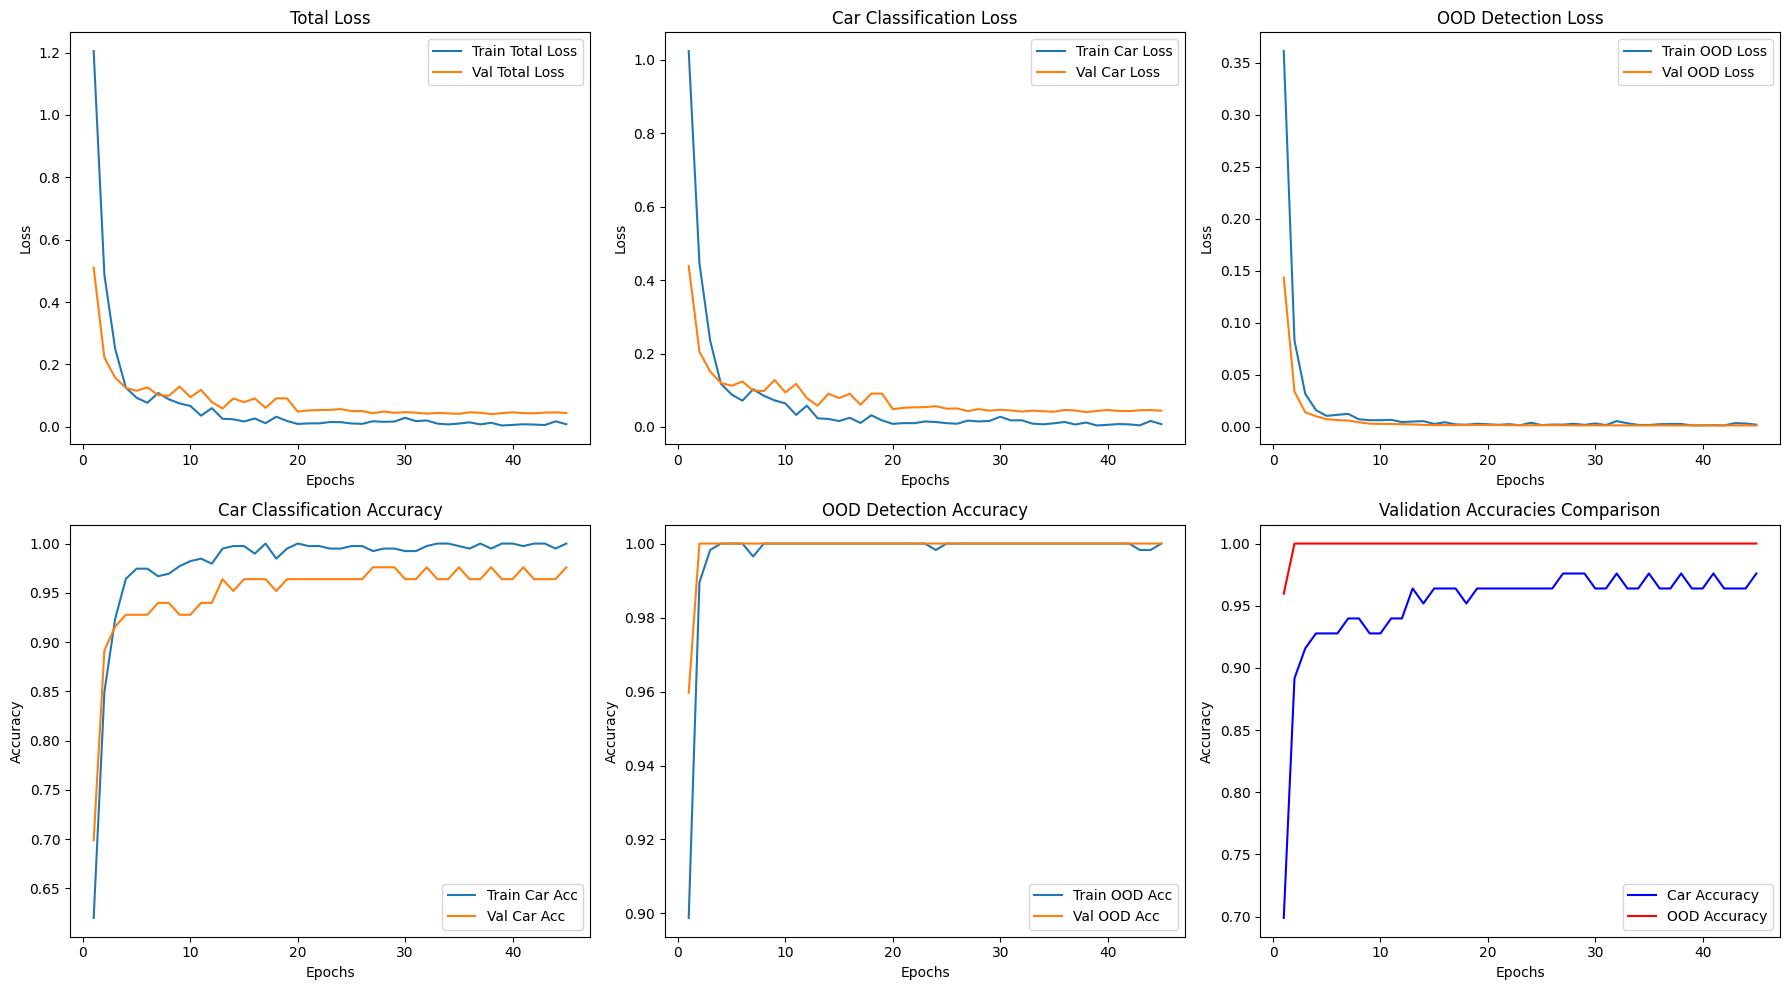

In [ ]:
EPOCHS = 50

if __name__ == "__main__":
    # Create early stopping object
    early_stopper = EarlyStopping(patience=7, min_delta=0.001)

    print("Starting training with Multi-Head OOD Detection...")

    # Execute training
    results = train_dual_head(model, train_dataloader, val_dataloader,
                             optimizer, EPOCHS, device, early_stopper, scheduler)

    # Final evaluation on test set
    test_loss, test_car_loss, test_ood_loss, test_car_acc, test_ood_acc = test_step_dual(
        model, test_dataloader, device
    )

    print(f"\nFinal Test Results:")
    print(f"Total Loss: {test_loss:.4f}")
    print(f"Car Classification - Loss: {test_car_loss:.4f} | Accuracy: {test_car_acc:.4f}")
    print(f"OOD Detection - Loss: {test_ood_loss:.4f} | Accuracy: {test_ood_acc:.4f}")

    # Visualize training progress
    plot_dual_metrics(results)


🔍 Testing OOD Detection with sample images...


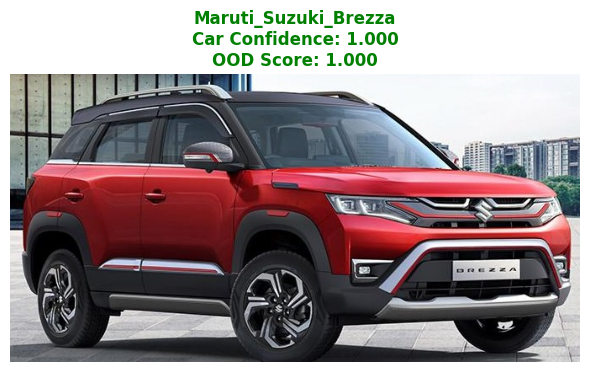

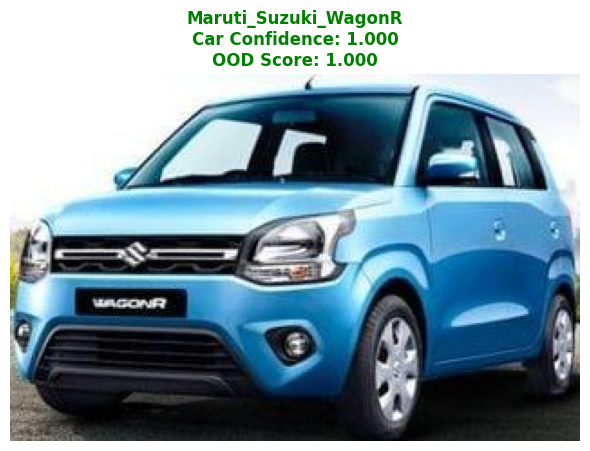

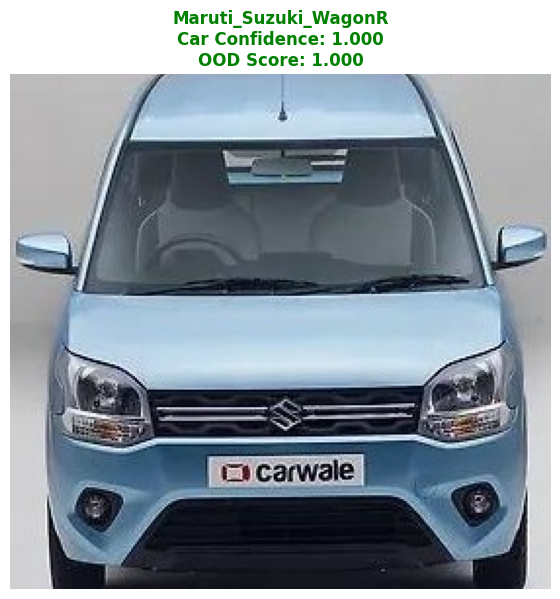

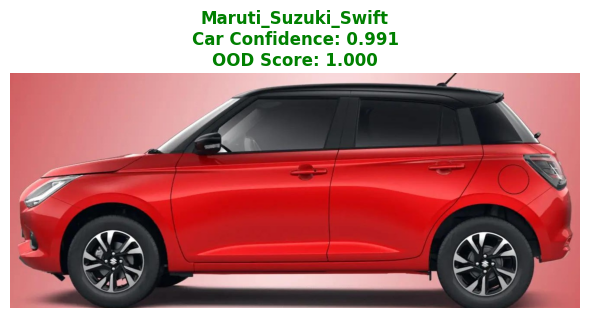

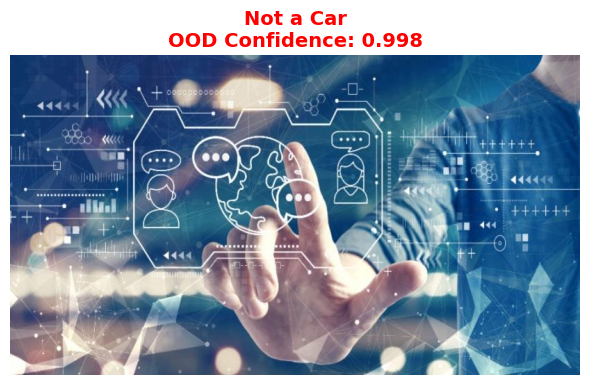

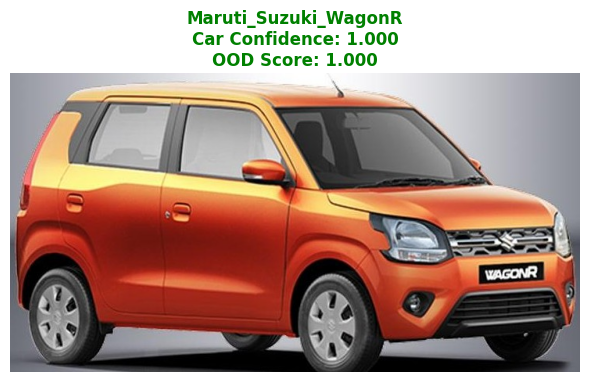

In [ ]:
print("\n🔍 Testing OOD Detection with sample images...")

# Test with sample images
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_sample = random.sample(population=test_image_path_list, k=6)

for image_path in test_image_sample:
    predict_with_ood_detection(model=model,
                              image_path=image_path,
                              class_names=class_names,
                              device=device,
                              ood_threshold=0.5)

# Testing Multiple Images at once

C:\Users\mistr\AppData\Local\Temp\ipykernel_20228\25291766.py:69: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


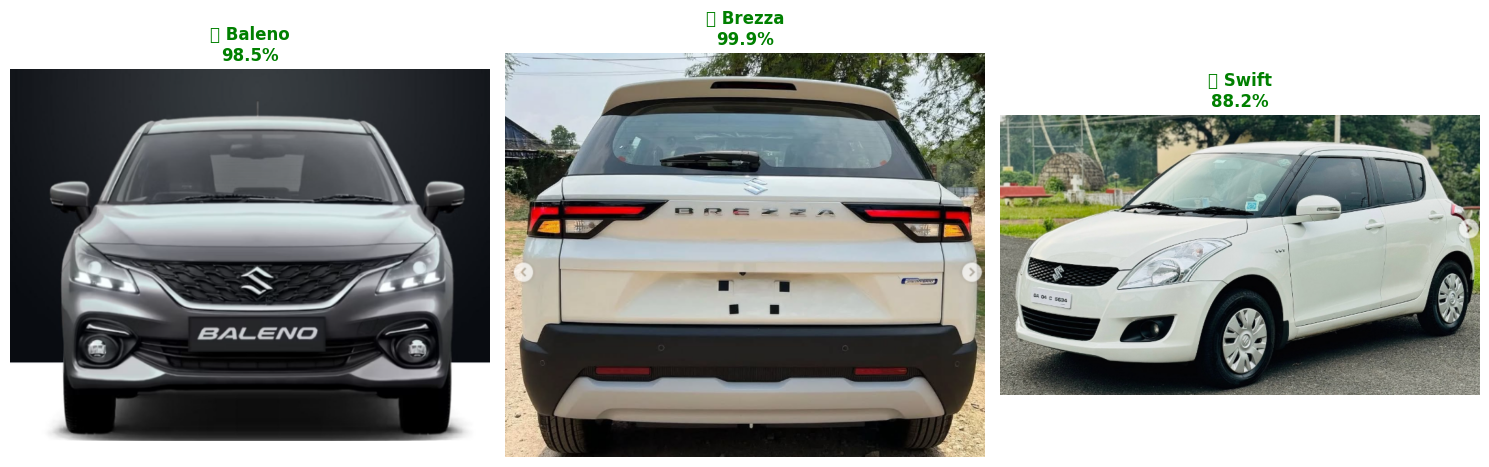

In [ ]:
def batch_predict_with_images_robust(image_paths):
    """Test multiple images and display them in a grid"""

    num_images = len(image_paths)
    cols = 3
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))

    # Normalize axes to always be indexable by [row][col]
    if rows == 1 and cols == 1:
        axes = [[axes]]  # Single subplot
    elif rows == 1:
        axes = [axes.flatten()]  # Single row, multiple columns
    elif cols == 1:
        axes = [[ax] for ax in axes.flatten()]  # Single column, multiple rows

    # For multiple rows and cols, axes is already 2D
    for idx, image_path in enumerate(image_paths):
        row = idx // cols
        col = idx % cols

        try:
            # Get prediction
            preprocess = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            image = Image.open(image_path).convert('RGB')
            input_tensor = preprocess(image).unsqueeze(0).to(device)

            model.eval()
            with torch.no_grad():
                car_logits, ood_logits = model(input_tensor)
                ood_prob = torch.sigmoid(ood_logits).item()

                if ood_prob < 0.5:
                    title = f"❌ Not a Car\n{(1-ood_prob)*100:.1f}%"
                    color = 'red'
                else:
                    car_names = ['Baleno', 'Brezza', 'Swift', 'WagonR']
                    predicted = torch.argmax(car_logits, dim=1).item()
                    confidence = torch.softmax(car_logits, dim=1).max().item()
                    title = f"✅ {car_names[predicted]}\n{confidence*100:.1f}%"
                    color = 'green'

            # Display - now consistently indexable
            ax = axes[row][col]
            ax.imshow(image)
            ax.set_title(title, fontsize=12, fontweight='bold', color=color)
            ax.axis('off')

        except Exception as e:
            # Handle any errors (file not found, etc.)
            ax = axes[row][col]
            ax.text(0.5, 0.5, f"Error:\n{str(e)}",
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"Error loading {image_path}", color='orange')
            ax.axis('off')

    # Hide empty subplots
    for idx in range(num_images, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row][col].axis('off')

    plt.tight_layout()
    plt.show()

# Usage for multiple images
image_list = ["./Test_image_sample/baleno.png",
              "./Test_image_sample/brezza1.png",
              "./Test_image_sample/swift.png"]

batch_predict_with_images_robust(image_list)


#### Save Trained Model

In [ ]:
from datetime import datetime
import pickle
import json
import os

In [ ]:
def save_complete_model(model, results, class_names, save_dir="./saved_models"):
    """
    Save the complete model package for deployment - Robust version
    """
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # Get current timestamp for version control
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"car_classifier_{timestamp}"

    # 1. Save model state dict
    model_path = os.path.join(save_dir, f"{model_name}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"✅ Model weights saved: {model_path}")

    # 2. Save complete model
    full_model_path = os.path.join(save_dir, f"{model_name}_full.pth")
    torch.save(model, full_model_path)
    print(f"✅ Full model saved: {full_model_path}")

    # 3. Save training results
    results_path = os.path.join(save_dir, f"{model_name}_results.pkl")
    with open(results_path, 'wb') as f:
        pickle.dump(results, f)
    print(f"✅ Training results saved: {results_path}")

    # 4. Intelligently extract best accuracy
    def get_best_accuracy(results_dict):
        accuracy_keys = [k for k in results_dict.keys() if 'acc' in k.lower()]
        if not accuracy_keys:
            return 0.0
        best_acc = 0.0
        for key in accuracy_keys:
            if isinstance(results_dict[key], list) and len(results_dict[key]) > 0:
                max_acc = max(results_dict[key])
                best_acc = max(best_acc, max_acc)
        return best_acc

    def get_total_epochs(results_dict):
        for key, value in results_dict.items():
            if isinstance(value, list) and len(value) > 0:
                return len(value)
        return 0

    # Extract metrics safely
    final_accuracy = get_best_accuracy(results)
    total_epochs = get_total_epochs(results)

    # 4. Save model metadata
    metadata = {
        "model_name": model_name,
        "timestamp": timestamp,
        "class_names": class_names,
        "num_classes": len(class_names),
        "input_size": [224, 224],
        "architecture": "EfficientNet-B0",
        "final_best_accuracy": final_accuracy,
        "total_epochs": total_epochs,
        "normalization_mean": [0.485, 0.456, 0.406],
        "normalization_std": [0.229, 0.224, 0.225],
        "available_metrics": list(results.keys())
    }

    metadata_path = os.path.join(save_dir, f"{model_name}_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"✅ Metadata saved: {metadata_path}")

    return {
        "model_path": model_path,
        "full_model_path": full_model_path,
        "results_path": results_path,
        "metadata_path": metadata_path,
        "model_name": model_name
    }


# Execute the save function after training
if __name__ == "__main__":
    # After your training is complete
    saved_paths = save_complete_model(
        model=model,
        results=results,
        class_names=class_names
    )

    print(f"\n🎉 Model package saved successfully!")
    print(f"📦 Model name: {saved_paths['model_name']}")

#### Load Save Model

In [ ]:
import torch
import torchvision
import json
import os
from typing import Dict, Any, Tuple, Optional

In [ ]:

def universal_model_loader(model_path: str, metadata_path: str, device: str = "cpu") -> Tuple[Optional[torch.nn.Module], Optional[Dict]]:
    """
    Universal model loader that handles both full models and state dicts

    Args:
        model_path: Path to model file (.pth)
        metadata_path: Path to metadata file (.json)
        device: Device to load model on

    Returns:
        Tuple of (model, metadata) or (None, None) if error
    """
    try:
        # Load metadata
        if not os.path.exists(metadata_path):
            print(f"❌ Metadata file not found: {metadata_path}")
            return None, None

        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

        if not os.path.exists(model_path):
            print(f"❌ Model file not found: {model_path}")
            return None, None

        print(f"🔍 Loading model from: {model_path}")

        # Load the saved object
        saved_object = torch.load(model_path, map_location=device)

        # Determine what type of object was saved
        if isinstance(saved_object, dict):
            # It's a state dict
            print("⚙️ Loading from state dictionary...")

            # Recreate model architecture
            model = torchvision.models.efficientnet_b0(weights=None)

            # Recreate classifier
            num_classes = metadata.get('num_classes', 4)
            model.classifier = torch.nn.Sequential(
                torch.nn.Dropout(p=0.2, inplace=True),
                torch.nn.Linear(1280, num_classes)
            )

            # Load weights
            model.load_state_dict(saved_object)

        else:
            # It's a full model
            print("📦 Loading full model...")
            model = saved_object

        # Set model to evaluation mode and move to device
        model.eval()
        model.to(device)

        print(f"✅ Model loaded successfully!")
        print(f"📊 Classes: {metadata.get('class_names', 'Not available')}")

        # Print accuracy if available
        accuracy_keys = ['final_test_accuracy', 'final_best_accuracy', 'test_accuracy']
        for key in accuracy_keys:
            if key in metadata:
                print(f"🎯 Accuracy: {metadata[key]:.4f}")
                break

        return model, metadata

    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        print(f"💡 Make sure the model file and metadata are compatible")
        return None, None

# Usage
model_loaded, metadata = universal_model_loader(
    model_path="./saved_models/car_classifier_20250731_210809_full.pth",
    metadata_path="./saved_models/car_classifier_20250731_210809_metadata.json",
    device="cpu"  # or "cuda" if you have GPU
)

if model_loaded is not None:
    print("🎉 Model ready for inference!")
else:
    print("❌ Failed to load model")


🔍 Loading model from: ./saved_models/car_classifier_20250731_210809_full.pth
📦 Loading full model...
✅ Model loaded successfully!
📊 Classes: ['Maruti_Suzuki_Baleno', 'Maruti_Suzuki_Brezza', 'Maruti_Suzuki_Swift', 'Maruti_Suzuki_WagonR']
🎯 Accuracy: 1.0000
🎉 Model ready for inference!


C:\Users\mistr\AppData\Local\Temp\ipykernel_20228\1456754563.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_object = torch.load(model_path, map_location=device)


#### Make Prediction Using Save Model

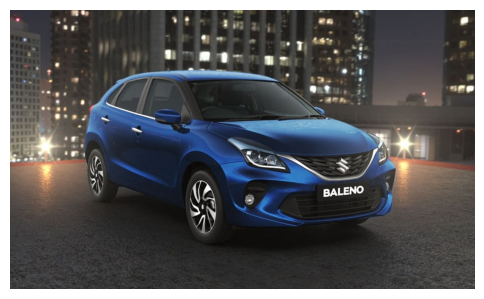

🚗 Predicted Car Model: Maruti_Suzuki_Baleno
🎯 Confidence: 1.000 (100.0%)


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_single_image_fixed(model, image_path, metadata, device):
    """
    prediction function that handles different model output types
    """
    try:
        # Load image
        image = Image.open(image_path).convert('RGB')

        # Preprocess image
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        input_tensor = preprocess(image).unsqueeze(0).to(device)

        # Make prediction
        model.eval()
        with torch.no_grad():
            model_output = model(input_tensor)

            # Handle different output types
            if isinstance(model_output, tuple):
                # If output is a tuple, take the first element (usually the main prediction)
                outputs = model_output[0]
                # print(f"ℹ️ Model returned tuple, using first element")
            else:
                # Single tensor output
                outputs = model_output

            # Ensure outputs is a tensor
            if not isinstance(outputs, torch.Tensor):
                raise ValueError(f"Expected tensor output, got {type(outputs)}")

            # print(f"📊 Final output shape: {outputs.shape}")

            # Apply softmax to get probabilities
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted_idx = torch.max(probabilities, 1)

        # Get results
        predicted_class = metadata['class_names'][predicted_idx.item()]
        confidence_score = confidence.item()

        # Show image with prediction
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        # plt.title(f"Predicted: {predicted_class} | Confidence: {confidence_score:.3f}",
        #           fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.show()

        # Return results
        return {
            'predicted_class': predicted_class,
            'confidence': confidence_score,
            'predicted_index': predicted_idx.item(),
            'all_probabilities': probabilities[0].cpu().numpy().tolist()
        }

    except Exception as e:
        print(f"❌ Error in prediction: {e}")
        print(f"💡 Try reloading the model or check model compatibility")
        return None

# Usage
image_path = "./Test_image_sample/baleno2.jpg"
prediction = predict_single_image_fixed(model, image_path, metadata, device)

if prediction:
    print(f"🚗 Predicted Car Model: {prediction['predicted_class']}")
    print(f"🎯 Confidence: {prediction['confidence']:.3f} ({prediction['confidence']*100:.1f}%)")
else:
    print("❌ Prediction failed")


#### Check The Size of Your Saved Model Files

In [ ]:
import os

def check_model_size(model_path):
    """
    Check the size of your saved model file

    Args:
        model_path: Path to your saved model file

    Returns:
        File size in bytes, KB, and MB
    """
    try:
        # Get file size in bytes
        size_bytes = os.path.getsize(model_path)

        # Convert to KB and MB
        size_kb = size_bytes / 1024
        size_mb = size_kb / 1024

        print(f"📁 Model File: {os.path.basename(model_path)}")
        print(f"📊 Size: {size_bytes:,} bytes")
        print(f"📊 Size: {size_kb:.2f} KB")
        print(f"📊 Size: {size_mb:.2f} MB")

        return size_bytes, size_kb, size_mb

    except FileNotFoundError:
        print(f"❌ File not found: {model_path}")
        return None
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Check your saved model
model_path = "./saved_models/car_classifier_20250731_210809_full.pth"
check_model_size(model_path)


📁 Model File: car_classifier_20250731_210809_full.pth
📊 Size: 16,421,926 bytes
📊 Size: 16037.04 KB
📊 Size: 15.66 MB


(16421926, 16037.037109375, 15.661169052124023)

#### Check All Saved Model Files

In [ ]:
import os
from pathlib import Path

def check_all_model_files(saved_models_dir="./saved_models"):
    """
    Check sizes of all saved model files in directory
    """
    try:
        model_dir = Path(saved_models_dir)

        if not model_dir.exists():
            print(f"❌ Directory not found: {saved_models_dir}")
            return

        print(f"🔍 Checking models in: {saved_models_dir}")
        print("-" * 60)

        # Find all model files
        model_files = list(model_dir.glob("*.pth")) + list(model_dir.glob("*.pkl")) + list(model_dir.glob("*.json"))

        if not model_files:
            print("❌ No model files found in directory")
            return

        total_size = 0

        for file_path in sorted(model_files):
            try:
                size_bytes = file_path.stat().st_size
                size_mb = size_bytes / (1024 * 1024)
                total_size += size_bytes

                print(f"📄 {file_path.name}")
                print(f"   Size: {size_bytes:,} bytes ({size_mb:.2f} MB)")
                print()

            except Exception as e:
                print(f"❌ Error reading {file_path.name}: {e}")

        print("-" * 60)
        print(f"📦 Total size: {total_size:,} bytes ({total_size/(1024*1024):.2f} MB)")

    except Exception as e:
        print(f"❌ Error: {e}")

# Check all your saved models
check_all_model_files()


🔍 Checking models in: ./saved_models
------------------------------------------------------------
📄 car_classifier_20250731_210809.pth
   Size: 16,369,664 bytes (15.61 MB)

📄 car_classifier_20250731_210809_full.pth
   Size: 16,421,926 bytes (15.66 MB)

📄 car_classifier_20250731_210809_metadata.json
   Size: 880 bytes (0.00 MB)

📄 car_classifier_20250731_210809_results.pkl
   Size: 4,254 bytes (0.00 MB)

------------------------------------------------------------
📦 Total size: 32,796,724 bytes (31.28 MB)
